In [1]:
#All libraries used 
import pandas as pd
import geopandas as gpd 
from shapely.geometry import Point 
import matplotlib.pyplot as plt 
from geopy.geocoders import Nominatim 
from tqdm import tqdm 
import contextily as ctx 
from geopy.distance import geodesic as GD  
import numpy as np
from shapely import wkt 
import plotly.express as px
import seaborn as sns
import numpy as np
from io import StringIO
from scipy import stats

In [2]:
pd.set_option('display.max_columns', None)

Loading CSV file with illegal mines coordinates

In [3]:
df_inter = pd.read_csv('Illegal-Airstrips-NYT-Intercept-Public.csv')
df_inter.head()

,Unnamed: 0,Airstrip ID,Original source of the airstrip’s location,Mining activity seen up to 20km of airstrip location,Latitude,Longitude,Attribution
0,0,48,Earthrise Media,True,3.116716,-63.707804,Collected as part of investigations by The Int...
1,1,61,Earthrise Media,True,2.759328,-62.908305,Collected as part of investigations by The Int...
2,2,66,Open Street Maps,True,2.687089,-63.352787,Collected as part of investigations by The Int...
3,3,67,Earthrise Media,True,2.658127,-63.153158,Collected as part of investigations by The Int...
4,4,68,Earthrise Media,True,2.630448,-63.040157,Collected as part of investigations by The Int...


Loading Amazon Vector (https://cartographyvectors.com/map/1255-amazon-basin#google_vignette)

In [4]:
amazon_vector = "amazon-basin_1255.geojson"
amazon_gdf = gpd.read_file(amazon_vector)

In [5]:
amazon_gdf.head()

,FEATURECLA,NAME,NAMEALT,REGION,SUBREGION,MIN_LABEL,MAX_LABEL,SCALERANK,LABEL,WIKIDATAID,NAME_AR,NAME_BN,NAME_DE,NAME_EN,NAME_ES,NAME_FR,NAME_EL,NAME_HI,NAME_HU,NAME_ID,NAME_IT,NAME_JA,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,NE_ID,NAME_FA,NAME_HE,NAME_UK,NAME_UR,NAME_ZHT,geometry
0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地,"MULTIPOLYGON (((-59.70096 1.82974, -59.89306 2..."


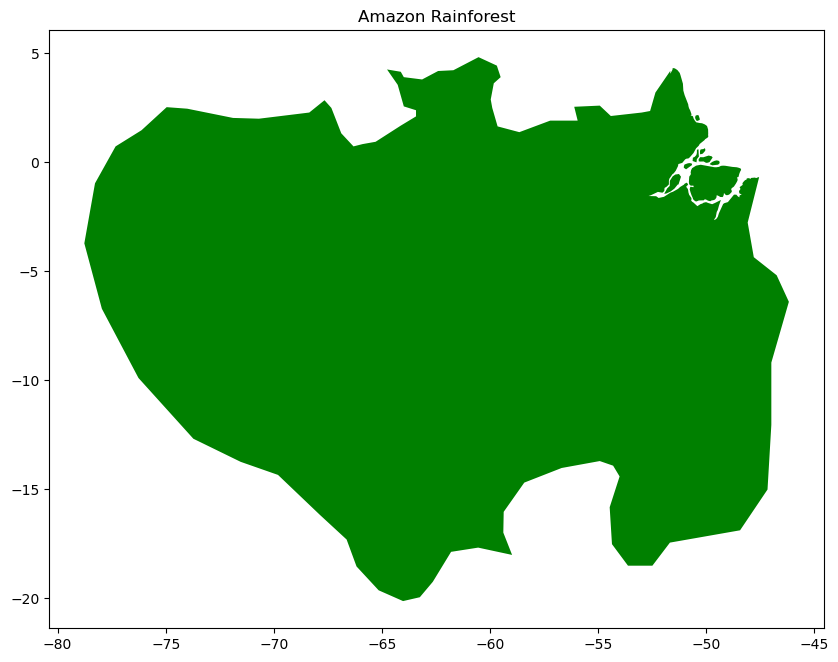

In [6]:
# Plot the Amazon Rainforest using geopandas
amazon_gdf.plot(figsize=(10, 10), color='green')

# Add title and display 
plt.title('Amazon Rainforest')
plt.show()

# Adding points to plot

In [7]:
# Create a GeoDataFrame with the Latitude and Longitude
geometry = [Point(xy) for xy in zip(df_inter['Longitude'], df_inter['Latitude'])]
geo_df = gpd.GeoDataFrame(df_inter, geometry=geometry)

# Set the Coordinate Reference System (CRS) to WGS84 (EPSG:4326)
geo_df.set_crs("EPSG:4326", inplace=True)

# Display the GeoDataFrame
geo_df.head()

,Unnamed: 0,Airstrip ID,Original source of the airstrip’s location,Mining activity seen up to 20km of airstrip location,Latitude,Longitude,Attribution,geometry
0,0,48,Earthrise Media,True,3.116716,-63.707804,Collected as part of investigations by The Int...,POINT (-63.70780 3.11672)
1,1,61,Earthrise Media,True,2.759328,-62.908305,Collected as part of investigations by The Int...,POINT (-62.90831 2.75933)
2,2,66,Open Street Maps,True,2.687089,-63.352787,Collected as part of investigations by The Int...,POINT (-63.35279 2.68709)
3,3,67,Earthrise Media,True,2.658127,-63.153158,Collected as part of investigations by The Int...,POINT (-63.15316 2.65813)
4,4,68,Earthrise Media,True,2.630448,-63.040157,Collected as part of investigations by The Int...,POINT (-63.04016 2.63045)


In [8]:
geo_df.value_counts("Mining activity seen up to 20km of airstrip location")

Mining activity seen up to 20km of airstrip location
False    907
True     362
dtype: int64

In [9]:
geo_df['Mining activity seen up to 20km of airstrip location'] = geo_df['Mining activity seen up to 20km of airstrip location'].astype(bool)

In [10]:
geo_df.value_counts("Mining activity seen up to 20km of airstrip location")

Mining activity seen up to 20km of airstrip location
False    907
True     362
dtype: int64

In [11]:
geo_df = geo_df[geo_df['Mining activity seen up to 20km of airstrip location'] == True]

In [12]:
geo_df.value_counts('Mining activity seen up to 20km of airstrip location')

Mining activity seen up to 20km of airstrip location
True    362
dtype: int64

Mapping only points that are inside the Amazon

In [13]:
# Ensure both GeoDataFrames use the same CRS
geo_df = geo_df.to_crs("EPSG:4326")
amazon_gdf = amazon_gdf.to_crs("EPSG:4326")

In [14]:
# Perform a spatial join to keep only the points within the Amazon boundary
points_within_amazon_inter = gpd.sjoin(geo_df, amazon_gdf, how="inner", op="within")

# Display the filtered GeoDataFrame
points_within_amazon_inter.head()


/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,Unnamed: 0,Airstrip ID,Original source of the airstrip’s location,Mining activity seen up to 20km of airstrip location,Latitude,Longitude,Attribution,geometry,index_right,FEATURECLA,NAME,NAMEALT,REGION,SUBREGION,MIN_LABEL,MAX_LABEL,SCALERANK,LABEL,WIKIDATAID,NAME_AR,NAME_BN,NAME_DE,NAME_EN,NAME_ES,NAME_FR,NAME_EL,NAME_HI,NAME_HU,NAME_ID,NAME_IT,NAME_JA,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,NE_ID,NAME_FA,NAME_HE,NAME_UK,NAME_UR,NAME_ZHT
0,0,48,Earthrise Media,True,3.116716,-63.707804,Collected as part of investigations by The Int...,POINT (-63.70780 3.11672),0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
1,1,61,Earthrise Media,True,2.759328,-62.908305,Collected as part of investigations by The Int...,POINT (-62.90831 2.75933),0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
2,2,66,Open Street Maps,True,2.687089,-63.352787,Collected as part of investigations by The Int...,POINT (-63.35279 2.68709),0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
3,3,67,Earthrise Media,True,2.658127,-63.153158,Collected as part of investigations by The Int...,POINT (-63.15316 2.65813),0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
4,4,68,Earthrise Media,True,2.630448,-63.040157,Collected as part of investigations by The Int...,POINT (-63.04016 2.63045),0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地


In [102]:
points_within_amazon_inter

,Unnamed: 0,Airstrip ID,Original source of the airstrip’s location,Mining activity seen up to 20km of airstrip location,Latitude,Longitude,Attribution,geometry,index_right,FEATURECLA,NAME,NAMEALT,REGION,SUBREGION,MIN_LABEL,MAX_LABEL,SCALERANK,LABEL,WIKIDATAID,NAME_AR,NAME_BN,NAME_DE,NAME_EN,NAME_ES,NAME_FR,NAME_EL,NAME_HI,NAME_HU,NAME_ID,NAME_IT,NAME_JA,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,NE_ID,NAME_FA,NAME_HE,NAME_UK,NAME_UR,NAME_ZHT
0,0,48,Earthrise Media,True,3.116716,-63.707804,Collected as part of investigations by The Int...,POINT (-63.70780 3.11672),0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
1,1,61,Earthrise Media,True,2.759328,-62.908305,Collected as part of investigations by The Int...,POINT (-62.90831 2.75933),0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
2,2,66,Open Street Maps,True,2.687089,-63.352787,Collected as part of investigations by The Int...,POINT (-63.35279 2.68709),0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
3,3,67,Earthrise Media,True,2.658127,-63.153158,Collected as part of investigations by The Int...,POINT (-63.15316 2.65813),0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
4,4,68,Earthrise Media,True,2.630448,-63.040157,Collected as part of investigations by The Int...,POINT (-63.04016 2.63045),0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,357,1652,The Intercept Brasil/The New York Times,True,-5.311217,-57.660228,Collected as part of investigations by The Int...,POINT (-57.66023 -5.31122),0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken

In [15]:
points_within_amazon_inter.to_excel('illegal_mines.xlsx')

### Cities table, table 1 (https://informe.ensp.fiocruz.br/assets/anexos/2441a041be660fb7575f8fe0bf6f8f34.PDF)

In [16]:
df = pd.read_csv('illegal_mines.csv')
df

,Unnamed: 0.1,Unnamed: 0,Mine ID,Original source of the airstrip’s location,Mining activity seen up to 20km of airstrip location,Latitude,Longitude,Attribution,geometry,index_right,FEATURECLA,NAME,NAMEALT,REGION,SUBREGION,MIN_LABEL,MAX_LABEL,SCALERANK,LABEL,WIKIDATAID,NAME_AR,NAME_BN,NAME_DE,NAME_EN,NAME_ES,NAME_FR,NAME_EL,NAME_HI,NAME_HU,NAME_ID,NAME_IT,NAME_JA,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,NE_ID,NAME_FA,NAME_HE,NAME_UK,NAME_UR,NAME_ZHT
0,0,0,48,Earthrise Media,True,3.116716,-63.707804,Collected as part of investigations by The Int...,POINT (-63.70780353 3.11671623),0,Basin,AMAZON BASIN,NaN,South America,NaN,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
1,1,1,61,Earthrise Media,True,2.759328,-62.908305,Collected as part of investigations by The Int...,POINT (-62.90830532 2.75932812),0,Basin,AMAZON BASIN,NaN,South America,NaN,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
2,2,2,66,Open Street Maps,True,2.687089,-63.352787,Collected as part of investigations by The Int...,POINT (-63.352787 2.6870895),0,Basin,AMAZON BASIN,NaN,South America,NaN,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
3,3,3,67,Earthrise Media,True,2.658127,-63.153158,Collected as part of investigations by The Int...,POINT (-63.15315757 2.658127422),0,Basin,AMAZON BASIN,NaN,South America,NaN,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
4,4,4,68,Earthrise Media,True,2.630448,-63.040157,Collected as part of investigations by The Int...,POINT (-63.04015719 2.630448232),0,Basin,AMAZON BASIN,NaN,South America,NaN,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,357,357,1652,The Intercept Brasil/The New York Times,True,-5.311217,-57.660228,Collected as part of investigations by The Int...,POINT (-57.6602277 -5.311216855),0,Basin,AMAZON BASIN,NaN,South America,NaN,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon

In [17]:
df_cities = pd.read_csv('municipio.csv')

In [18]:
df_cities

,Município (UF),N° de Peixes,N° de Espécies,Média Hg ug/g (D.P),Mediana Hg,Mín. - Máx. Hg,Média Hg ug/g Carnívoros (n),Média Hg ug/g Não-carnívoros (n),"% 0,5 ug/g"
0,Altamira (PA),43,13,"0,30 (0,37)","0,21","0,0 1,55","0,46 (25)","0,08 (18)","13,95"
1,Belém (PA),70,24,"0,20 (0,33)","0,08","0,0-2,39","0,29 (46)","0,03 (24)","8,57"
2,Boa Vista (RR),75,27,"0,55 (0,65)","0,41","0,0-3,56","0,87 (43)","0,12 (32)","40,00"
3,Humaitá (AM),60,20,"0,36 (0,53)","0,14","0,0-2,34","0,65 (25)","0,15 (35)","25,00"
4,Itaituba (PA),71,24,"0,29 (0,39)","0,09","0,0 - 1,63","0,65 (26)","0,08 (45)","21,13"
5,Macapá (AP),73,25,"0,17 (0,24)","0,09","0,0 1,24","0,28 (42)","0,03 (31)","10,96"
6,Manaus (AM),51,18,"0,42 (0,53)","0,16","0,0-2 2,18","0,85 (21)","0,12 (30)","27,45"
7,Maraã (AM),48,15,"0,12 (0,12)","0,08","0,0 - 0,52","0,33 (6)","0,10 (42)","2,08"
8,Oiapoque (AP),41,12,"0,19 (0,28)","0,08","0,0 - 1,13","0,25 (32)","0,0 (9)","12,20"
9,Oriximina (PA),71,21,"0,20 (0,30)","0,06","0,0 - 1,25","0,47 (21)","0,09 (50)","14,08"


In [19]:
df_cities.to_csv('fish_poisoning.csv')

In [20]:
df_cities[['Município', '(UF)']] = df_cities["Município (UF)"].str.split(" ", n=1, expand=True)
df_cities

,Município (UF),N° de Peixes,N° de Espécies,Média Hg ug/g (D.P),Mediana Hg,Mín. - Máx. Hg,Média Hg ug/g Carnívoros (n),Média Hg ug/g Não-carnívoros (n),"% 0,5 ug/g",Município,(UF)
0,Altamira (PA),43,13,"0,30 (0,37)","0,21","0,0 1,55","0,46 (25)","0,08 (18)","13,95",Altamira,(PA)
1,Belém (PA),70,24,"0,20 (0,33)","0,08","0,0-2,39","0,29 (46)","0,03 (24)","8,57",Belém,(PA)
2,Boa Vista (RR),75,27,"0,55 (0,65)","0,41","0,0-3,56","0,87 (43)","0,12 (32)","40,00",Boa,Vista (RR)
3,Humaitá (AM),60,20,"0,36 (0,53)","0,14","0,0-2,34","0,65 (25)","0,15 (35)","25,00",Humaitá,(AM)
4,Itaituba (PA),71,24,"0,29 (0,39)","0,09","0,0 - 1,63","0,65 (26)","0,08 (45)","21,13",Itaituba,(PA)
5,Macapá (AP),73,25,"0,17 (0,24)","0,09","0,0 1,24","0,28 (42)","0,03 (31)","10,96",Macapá,(AP)
6,Manaus (AM),51,18,"0,42 (0,53)","0,16","0,0-2 2,18","0,85 (21)","0,12 (30)","27,45",Manaus,(AM)
7,Maraã (AM),48,15,"0,12 (0,12)","0,08","0,0 - 0,52","0,33 (6)","0,10 (42)","2,08",Maraã,(AM)
8,Oiapoque (AP),41,12,"0,19 (0,28)","0,08","0,0 - 1,13","0,25 (32)","0,0 (9)","12,20",Oiapoque,(AP)
9,Oriximina (PA),71,21,"0,20 (0,30)","0,06","0,0 - 1,25","0,47 (21)","0,09 (50)","14,08",Oriximina,(PA)


In [21]:
df_cities['Latitude'] = None
df_cities['Longitude'] = None

In [22]:
geolocator = Nominatim(user_agent="municipios_geocoder")

In [23]:
# Function to get latitude and longitude
def get_lat_long(municipio):
    try:
        location = geolocator.geocode(f"{municipio}, Brazil")
        if location:
            return location.latitude, location.longitude
        #Returning None if nothing is found
        else:
            return None, None
    except:
        return None, None

In [24]:
# Apply the function to each row in the municipio column
for index, row in tqdm(df_cities.iterrows(), total=df_cities.shape[0]):
    lat, long = get_lat_long(row['Município'])
    df_cities.at[index, 'Latitude'] = lat
    df_cities.at[index, 'Longitude'] = long

100%|███████████████████████████████████████████| 17/17 [00:10<00:00,  1.61it/s]


In [25]:
df_cities

,Município (UF),N° de Peixes,N° de Espécies,Média Hg ug/g (D.P),Mediana Hg,Mín. - Máx. Hg,Média Hg ug/g Carnívoros (n),Média Hg ug/g Não-carnívoros (n),"% 0,5 ug/g",Município,(UF),Latitude,Longitude
0,Altamira (PA),43,13,"0,30 (0,37)","0,21","0,0 1,55","0,46 (25)","0,08 (18)","13,95",Altamira,(PA),-3.204065,-52.209961
1,Belém (PA),70,24,"0,20 (0,33)","0,08","0,0-2,39","0,29 (46)","0,03 (24)","8,57",Belém,(PA),-1.45056,-48.468245
2,Boa Vista (RR),75,27,"0,55 (0,65)","0,41","0,0-3,56","0,87 (43)","0,12 (32)","40,00",Boa,Vista (RR),-23.186168,-45.887245
3,Humaitá (AM),60,20,"0,36 (0,53)","0,14","0,0-2,34","0,65 (25)","0,15 (35)","25,00",Humaitá,(AM),-27.566056,-53.971982
4,Itaituba (PA),71,24,"0,29 (0,39)","0,09","0,0 - 1,63","0,65 (26)","0,08 (45)","21,13",Itaituba,(PA),-4.262522,-55.987814
5,Macapá (AP),73,25,"0,17 (0,24)","0,09","0,0 1,24","0,28 (42)","0,03 (31)","10,96",Macapá,(AP),0.040153,-51.056959
6,Manaus (AM),51,18,"0,42 (0,53)","0,16","0,0-2 2,18","0,85 (21)","0,12 (30)","27,45",Manaus,(AM),-3.131633,-59.982504
7,Maraã (AM),48,15,"0,12 (0,12)","0,08","0,0 - 0,52","0,33 (6)","0,10 (42)","2,08",Maraã,(AM),-1.853558,-65.589775
8,Oiapoque (AP),41,12,"0,19 (0,28)","0,08","0,0 - 1,13","0,25 (32)","0,0 (9)","12,20",Oiapoque,(AP),3.843213,-51.83508
9,Oriximina (PA),71,21,"0,20 (0,30)","0,06","0,0 - 1,25","0,47 (21)","0,09 (50)","14,08",Oriximina,(PA),-1.766999,-55.868285


In [27]:
geo_cities_within_basin.to_csv('fish_kill.csv')

In [29]:
lst= ['AC', 'AM', 'RO', 'RR', 'PA', 'MA', 'TO', 'MS']

In [30]:
import dask_geopandas as dgpd
import dask.dataframe as dd

def read_files(lst):
    states_lst = []
    
    for state in lst:
        shapefile_path = f'/Users/annakarolynepereira/Downloads/{state}/{state}'
        # Specify npartitions when reading the file
        states = dgpd.read_file(f'{shapefile_path}.shp', npartitions=10)  # Adjust npartitions as needed
        states_lst.append(states)

    # Concatenate all Dask GeoDataFrames using dask.dataframe.concat
    lm = dd.concat(states_lst)

    # Optionally, persist to cache it
    lm = lm.persist()

    # Compute the final result to bring it into memory as a GeoDataFrame
    lm = lm.compute()

    return lm


In [31]:
lm = read_files(lst)

/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/pyogrio/core.py:279: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read_info(
/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read(
/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/pyogrio/core.py:279: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read_info(
/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read(
/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/pyogri

/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read(
/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read(
/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read(
/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:198: UserWarning: Measured (M) geometry types are not supported. Original type 'Measured 3D Polygon' is converted to 'Polygon Z'
  return ogr_read(
/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/pyogrio/raw.py:198

In [32]:
lm

,PROCESSO,NUMERO,ANO,AREA_HA,ID,FASE,ULT_EVENTO,NOME,SUBS,USO,UF,DSProcesso,geometry
0,880147/1979,880147,1979,9800.00,{091DBD66-885B-4F55-B476-A79C26B28246},AUTORIZAÇÃO DE PESQUISA,294 - AUT PESQ/RENÚNCIA AUT PESQ HOMOLOGADA PU...,MINERAÇÃO IGUAPO LTDA,WOLFRAMITA,Demais substâncias,AC,880.147/1979,"POLYGON Z ((-73.65896 -7.36562 0.00000, -73.65..."
1,880954/1985,880954,1985,50.00,{3AE579FD-F0B7-4CA1-A18B-77E3F9C942B6},CONCESSÃO DE LAVRA,470 - CONC LAV/EXIGÊNCIA PUBLICADA EM 16/09/2024,VERONA MINERACAO INDUSTRIA E COMERCIO EIRELI,ÁGUA MINERAL,Demais substâncias,AC,880.954/1985,"POLYGON Z ((-67.73617 -10.13297 0.00000, -67.7..."
2,880002/1992,880002,1992,50.00,{734009C7-11D1-4D7F-9BB3-551A280D136E},CONCESSÃO DE LAVRA,694 - PAGAMENTO VISTORIA FISCALIZAÇÃO EFETUADO...,EMPRESA DE AGUA MINERAL MONTE MARIO LTDA,ÁGUA MINERAL,Demais substâncias,AC,880.002/1992,"POLYGON Z ((-67.80873 -10.00312 0.00000, -67.8..."
3,886607/1995,886607,1995,50.00,{01E0A367-8AD6-4120-A00B-86EDA81CBC5A},AUTORIZAÇÃO DE PESQUISA,318 - AUT PESQ/RELATORIO PESQ NÃO APV ART 30 I...,JOSÉ BERNARDO DA SILVA,ÁGUA MINERAL,Demais substâncias,AC,886.607/1995,"POLYGON Z ((-67.81858 -9.92348 0.00000, -67.81..."
4,886163/2000,886163,2000,50.00,{436190EF-698A-406B-BBAA-FD90774778CE},CONCESSÃO DE LAVRA,448 - CONC LAV/ROTULO ÁGUA MINERAL PROTOCOLIZA...,DILSON A. RIBEIRO,ÁGUA MINERAL,Engarrafamento,AC,886.163/2000,"POLYGON Z ((-67.72989 -10.16357 0.00000, -67.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3306,300139/2024,300139,2024,379.59,{99D74862-DEB7-4A1A-83DD-7C65ADC1400D},DISPONIBILIDADE,1828 - DISPONIB/ÁREA DESCARTADA LIBERADA PARA ...,DADO NÃO CADASTRADO,DADO NÃO CADASTRADO,DADO NÃO CADASTRADO,DADO NÃO CADASTRADO,300.139/2024,"POLYGON Z ((-56.58742 -20.83779 0.00000, -56.5..."
3307,868009/2018,868009,2018,50.00,{CCDA19E0-9F1A-46B7-8C22-60A1493C764E},DISPONIBILIDADE,2468 - DISPONIB/LEILÃO ELETRONICO AREA PARA PE...,Mineração e Transporte Diamante Azul Ltda,BASALTO,Brita,MS,868.009/2018,"POLYGON Z ((-51.07042 -19.72394 0.00000, -51.0..."
3308,868018/2018,868018,2018,1000.00,{96013113-C726-45C8-987D-FE7A746CF130},DISPONIBILIDADE,2338 - DISPONIB/EDITAL OFERTA PUBLICA PARA PES...,Brás Antônio Ovídio,MINÉRIO DE COBRE,Industrial,MS,868.018/2018,"POLYGON Z ((-51.02991 -20.05754 0.00000, -51.0..."
3309,868244/2016,868244,2016,315.53,{C3B3231A-9C7E-41BC-AC10-603505549F8F},DISPONIBILIDADE,2468 - DISPONIB/LEILÃO ELETRONICO AREA PARA PE...,Luis Gustavo Azarias Pereira,AREIA,Construção civil,MS,868.244/2016,"POLYGON Z ((-55.67321 -20.47485 0.00000, -55.6..."


In [35]:
lm = gpd.sjoin(lm, amazon_gdf, how="inner", op="within")


/Users/annakarolynepereira/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/76/p2hdmvbd5j138stdw2t1sk4m0000gn/T/ipykernel_56305/1838951821.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4674
Right CRS: EPSG:4326

  lm = gpd.sjoin(lm, amazon_gdf, how="inner", op="within")


In [36]:
lm = lm.to_crs(amazon_gdf.crs)

In [41]:
lm_300 = lm.sample(n=300)

In [38]:
lm_300

,PROCESSO,NUMERO,ANO,AREA_HA,ID,FASE,ULT_EVENTO,NOME,SUBS,USO,UF,DSProcesso,geometry,index_right,FEATURECLA,NAME,NAMEALT,REGION,SUBREGION,MIN_LABEL,MAX_LABEL,SCALERANK,LABEL,WIKIDATAID,NAME_AR,NAME_BN,NAME_DE,NAME_EN,NAME_ES,NAME_FR,NAME_EL,NAME_HI,NAME_HU,NAME_ID,NAME_IT,NAME_JA,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,NE_ID,NAME_FA,NAME_HE,NAME_UK,NAME_UR,NAME_ZHT
3375,880043/2024,880043,2024,2.71,{2E4161D6-9E5B-4BE7-991A-ECDB5FD90C7C},REQUERIMENTO DE PESQUISA,136 - REQ PESQ/DOCUMENTO DIVERSO PROTOCOLIZADO...,AMAZONIA TESOUROS E RESERVAS LTDA,MINÉRIO DE OURO,Industrial,AM,880.043/2024,"POLYGON Z ((-58.81189 -5.84373 0.00000, -58.81...",0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
5407,886271/2021,886271,2021,1.45,{24C3F9FB-9518-4787-AC65-54D5111FBF04},REQUERIMENTO DE LAVRA GARIMPEIRA,2112 - REQ PLG/EXIGENCIA OPÇÃO DE AREA EM 31/0...,COOPERATIVA DOS GARIMPEIROS E MINERADORES DO B...,CASSITERITA,Industrial,RO,886.271/2021,"POLYGON Z ((-61.82809 -9.40001 0.00000, -61.82...",0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
22462,752929/1996,752929,1996,49.89,{0362A2C2-CC24-45C0-8F37-3C9A3244579C},DISPONIBILIDADE,1352 - DISPONIB/TORNA S/EFEITO DISPONIB ART 26...,JENCKSIN LOPES CHAGAS,MINÉRIO DE OURO,Demais substâncias,PA,752.929/1996,"POLYGON Z ((-56.82133 -6.17560 0.00000, -56.82...",0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
20199,850394/2024,850394,2024,10.00,{5FF69211-D10E-4732-950F-199288DECC14},REQUERIMENTO DE LICENCIAMENTO,1149 - REQ LICEN/CUMPRIMENTO EXIGÊNCIA PROTOCO...,DEUS E FIEL MINERACAO LTDA,GRANITO,Revestimento,PA,850.394/2024,"POLYGON Z ((-49.86057 -4.11163 0.00000, -49.85...",0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地
767,886369/1998,886369,1998,50.00,{4658379A-B1B3-4C3F-A1C6-E246A6B02A5C},REQUERIMENTO DE LAVRA GARIMPEIRA,335 - REQ PLG/INDEFERIMENTO PUBLICADO EM 01/09...,LAERCIO DE OLIVEIRA BOTELHO,OURO,Demais substâncias,RO,886.369/1998,"POLYGON Z ((-64.67528 -9.28659 0.00000, -64.67...",0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆

In [90]:
# Check that lm_300 is a GeoDataFrame and has a geometry column
if not isinstance(lm_300, gpd.GeoDataFrame):
    lm_300 = gpd.GeoDataFrame(lm_300, geometry='geometry')

# Check if 'geometry' column exists and contains valid geometry data
if 'geometry' in lm_300.columns and lm_300.geometry.notnull().all():
    # Calculate the centroid for each geometry (Polygon or MultiPolygon)
    lm_300['centroid'] = lm_300.geometry.centroid

    # Extract the coordinates of the centroid into separate columns
    lm_300['Longitude'] = lm_300['centroid'].x
    lm_300['Latitude'] = lm_300['centroid'].y

    # Select only the necessary columns (replace 'NUMERO' if needed with actual ID column)
    if 'NUMERO' in lm_300.columns:
        centroid_df = lm_300[['NUMERO', 'Longitude', 'Latitude']]
        centroid_df.to_csv('mine_coordinates.csv', index=False)
        print(centroid_df)
    else:
        print("Error: 'NUMERO' column not found. Please check your unique identifier column name.")
else:
    print("Error: Geometry column is missing or contains null values.")



       NUMERO  Longitude   Latitude
1245   884154 -60.905421   2.451686
16426  850136 -56.200157  -6.753356
15288  850180 -57.366105  -6.650281
11405  851095 -56.471556  -5.830144
2384   880223 -63.301259  -7.807067
...       ...        ...        ...
2468   886293 -61.782759 -11.819068
2514   855127 -56.504555  -7.409487
2608   886149 -62.163760  -9.285989
19234  850879 -56.222401  -7.152255
3398   880048 -58.756105  -5.950500

[300 rows x 3 columns]


/var/folders/76/p2hdmvbd5j138stdw2t1sk4m0000gn/T/ipykernel_56305/3088099864.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lm_300['centroid'] = lm_300.geometry.centroid


In [91]:
centroid_df.rename(columns={"NUMERO": "Mine ID"}, inplace=True)

/var/folders/76/p2hdmvbd5j138stdw2t1sk4m0000gn/T/ipykernel_56305/462737362.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  centroid_df.rename(columns={"NUMERO": "Mine ID"}, inplace=True)


In [92]:
centroid_df.to_csv('centroid.csv')

In [88]:
centroid_df

,Mine ID,Longitude,Latitude
1245,884154,-60.905421,2.451686
16426,850136,-56.200157,-6.753356
15288,850180,-57.366105,-6.650281
11405,851095,-56.471556,-5.830144
2384,880223,-63.301259,-7.807067
...,...,...,...
2468,886293,-61.782759,-11.819068
2514,855127,-56.504555,-7.409487
2608,886149,-62.163760,-9.285989
19234,850879,-56.222401,-7.152255


In [84]:
lm_300

,PROCESSO,NUMERO,ANO,AREA_HA,ID,FASE,ULT_EVENTO,NOME,SUBS,USO,UF,DSProcesso,geometry,index_right,FEATURECLA,NAME,NAMEALT,REGION,SUBREGION,MIN_LABEL,MAX_LABEL,SCALERANK,LABEL,WIKIDATAID,NAME_AR,NAME_BN,NAME_DE,NAME_EN,NAME_ES,NAME_FR,NAME_EL,NAME_HI,NAME_HU,NAME_ID,NAME_IT,NAME_JA,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,NE_ID,NAME_FA,NAME_HE,NAME_UK,NAME_UR,NAME_ZHT,centroid,Longitude,Latitude
1245,884154/2014,884154,2014,573.69,{2B5B6CAB-CA96-41B3-A69C-104F0563CE07},APTO PARA DISPONIBILIDADE,2653 - DISPONIB/EDITAL DISPONIBILIDADE CANCELA...,Marco Antonio de Oliveira Rocha,GRANITO,Revestimento,RR,884.154/2014,"POLYGON Z ((-60.89432 2.46402 0.00000, -60.894...",0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地,POINT (-60.90542 2.45169),-60.905421,2.451686
16426,850136/2021,850136,2021,49.97,{1A6A8F8B-4667-49AD-B138-8AAAD9F95FB5},REQUERIMENTO DE LAVRA GARIMPEIRA,613 - REQ PLG/DESISTÊNCIA REQ PLG HOMOLOGADA P...,Vitor luiz gregolin,CASSITERITA,Industrial,PA,850.136/2021,"POLYGON Z ((-56.20415 -6.75088 0.00000, -56.19...",0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地,POINT (-56.20016 -6.75336),-56.200157,-6.753356
15288,850180/2020,850180,2020,50.00,{C92A07ED-091B-45C4-A8A8-D9255111FD89},REQUERIMENTO DE LAVRA GARIMPEIRA,2111 - REQ PLG/PROTOCOLO ORGÃO AMBIENTAL PROTO...,ANSELMO CAMPOS DE OLIVEIRA,MINÉRIO DE OURO,Industrial,PA,850.180/2020,"POLYGON Z ((-57.35706 -6.65141 0.00000, -57.37...",0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地,POINT (-57.36610 -6.65028),-57.366105,-6.650281
11405,851095/2016,851095,2016,50.00,{CE3791A3-0846-48F9-B078-EFCBFC201C28},REQUERIMENTO DE LAVRA GARIMPEIRA,2111 - REQ PLG/PROTOCOLO ORGÃO AMBIENTAL PROTO...,EDIMAR SOARES DE SOUZA,MINÉRIO DE OURO,Industrial,PA,851.095/2016,"POLYGON Z ((-56.46704 -5.83240 0.00000, -56.47...",0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λεκάνη του Αμαζονίου,अमेज़न बेसिन,Amazonas-medence,Basin Amazon,Bacino dell'Amazzonia,アマゾン盆地,아마존 분지,Amazonebekken,Nizina Amazonki,Bacia do rio Amazonas,Амазонская низменность,Amazonområdet,Amazon Havzası,Lưu vực Amazon,亞馬遜盆地,1159104325,حوضه آمازون,אמזוניה,Амазонська низовина,ایمیزون بیسن,亞馬遜盆地,POINT (-56.47156 -5.83014),-56.471556,-5.830144
2384,880223/2020,880223,2020,643.68,{8E9BBF73-A057-4D76-A4F5-673D90C29697},AUTORIZAÇÃO DE PESQUISA,265 - AUT PESQ/PRORROGAÇÃO PRAZO ALVARÁ SOLICI...,CARLOS GOMES CONSULTORIA E SERVICOS GEOLOGICOS...,MINÉRIO DE OURO,Industrial,AM,880.223/2020,"POLYGON Z ((-63.28634 -7.78991 0.00000, -63.28...",0,Basin,AMAZON BASIN,None,South America,None,2,6,1,AMAZON BASIN,Q244451,حوض الأمازون,আমাজন বেসিন,Amazonasbecken,Amazon basin,Cuenca del Amazonas,bassin amazonien,λ

In [89]:
fk

,mine_id,UF,distance_km,number_of_fish,number_of_species,mine_type,mean_value,mean_number,mean_carnivorous_value,mean_carnivorous_number,mean_non_carnivorous_value,mean_non_carnivorous_number
4,48,Maraã (AM),588.137112,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
14,61,Maraã (AM),590.948230,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
24,66,Maraã (AM),560.412052,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
34,67,Maraã (AM),567.813190,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
44,68,Maraã (AM),571.267422,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
...,...,...,...,...,...,...,...,...,...,...,...,...
295,886293,Manaus (AM),980.590346,51,18,Legal,0.42,0.53,0.85,21,0.12,30
296,855127,Itaituba (PA),352.355347,71,24,Legal,0.29,0.39,0.65,26,0.08,45
297,886149,Tefé (AM),711.441415,47,16,Legal,0.13,0.15,0.30,15,0.05,32
298,850879,Itaituba (PA),317.567373,71,24,Legal,0.29,0.39,0.65,26,0.08,45


In [39]:
lm_300.to_csv('lmines.csv')

/var/folders/76/p2hdmvbd5j138stdw2t1sk4m0000gn/T/ipykernel_56305/3504312281.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


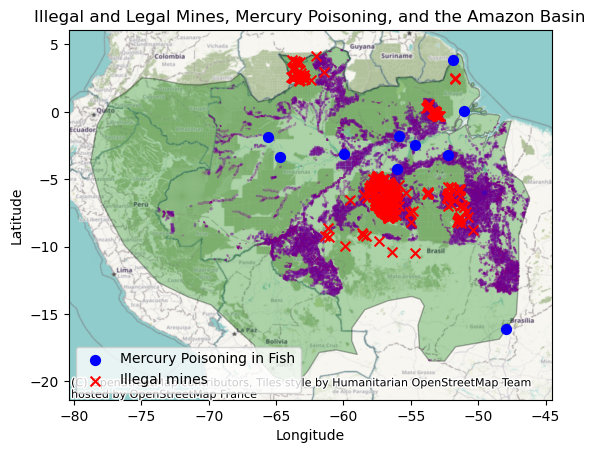

In [44]:
fig, ax = plt.subplots()

amazon_gdf.plot(ax=ax, color='green', alpha=0.3, edgecolor='black', label='Amazon Basin')
lm.plot(ax=ax, color='blue', alpha=0.3, edgecolor='purple', label= 'Legal Mines')
geo_cities_within_basin.plot(ax=ax, marker='o', color='blue', markersize=50, label='Mercury Poisoning in Fish')
points_within_amazon_inter.plot(ax=ax, marker='x', color='red', markersize=50, label='Illegal mines')

ctx.add_basemap(ax, crs=amazon_gdf.crs.to_string())

plt.title("Illegal and Legal Mines, Mercury Poisoning, and the Amazon Basin")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


# Creating dataframes for analysis

In [45]:
import pandas as pd
from shapely.geometry import Point, Polygon, MultiPolygon
from geopy.distance import geodesic

# Function to calculate the minimum distance from a mine polygon to a fish kill point
def calculate_distance_to_fish_kill(mine_geometry, fish_kill_point):
    min_distance = float('inf')

    # If the mine is a MultiPolygon
    if isinstance(mine_geometry, MultiPolygon):
        for polygon in mine_geometry.geoms:  # Access individual polygons using .geoms
            # Calculate the distance from the polygon's boundary to the fish kill point
            nearest_point_on_polygon = polygon.exterior.interpolate(polygon.exterior.project(fish_kill_point))
            nearest_point_coords = (nearest_point_on_polygon.y, nearest_point_on_polygon.x)
            fish_kill_coords = (fish_kill_point.y, fish_kill_point.x)
            distance = geodesic(fish_kill_coords, nearest_point_coords).kilometers
            if distance < min_distance:
                min_distance = distance
    else:
        # If it's a Polygon, calculate distance directly
        nearest_point_on_polygon = mine_geometry.exterior.interpolate(mine_geometry.exterior.project(fish_kill_point))
        nearest_point_coords = (nearest_point_on_polygon.y, nearest_point_on_polygon.x)
        fish_kill_coords = (fish_kill_point.y, fish_kill_point.x)
        min_distance = geodesic(fish_kill_coords, nearest_point_coords).kilometers

    return min_distance

# Create a list to store the results
results = []

# Iterate through each mine (polygons or multipolygons)
for _, mine_row in lm_300.iterrows():
    mine_geometry = mine_row['geometry']  # The polygon or multipolygon geometry from the DataFrame
    nearest_fish_kill_id = None
    min_distance = float('inf')  # Initialize with a very large number
    
    # Variables to store the nearest fish kill data
    nearest_fish_kill_data = {}

    # Iterate through each fish kill point
    for _, fish_kill_row in geo_cities_within_basin.iterrows():
        fish_kill_point = Point(fish_kill_row['Longitude'], fish_kill_row['Latitude'])  # Create a Point for the fish kill
        
        distance = calculate_distance_to_fish_kill(mine_geometry, fish_kill_point)
        
        if distance < min_distance:
            min_distance = distance
            nearest_fish_kill_id = fish_kill_row['Município (UF)']  # Store the nearest fish kill's ID
            # Store the nearest fish kill's data
            nearest_fish_kill_data = {
                'number_of_fish': fish_kill_row['N° de Peixes'],
                'number_of_species': fish_kill_row['N° de Espécies'],
                'mean': fish_kill_row['Média Hg ug/g (D.P)'],
                'median': fish_kill_row['Mediana Hg'],
                'mean_carnivorous': fish_kill_row['Média Hg ug/g Carnívoros (n)'],
                'mean_non_carnivorous': fish_kill_row['Média Hg ug/g Não-carnívoros (n)'],
                'percentage_0.5': fish_kill_row['% 0,5 ug/g']
            }

    # Store the nearest fish kill and the distance for each mine
    results.append({
        'mine_id': mine_row['NUMERO'],  # Store the mine's ID
        'nearest_fish_kill_id': nearest_fish_kill_id,
        'distance_km': min_distance,
        **nearest_fish_kill_data  # Unpack the nearest fish kill's data into the dictionary
    })

# Convert the results to a DataFrame
legal_fk = pd.DataFrame(results)

# Display the nearest fish kills to each mine
print(legal_fk)


     mine_id nearest_fish_kill_id  distance_km  number_of_fish  \
0     884154          Manaus (AM)   624.501584              51   
1     850136        Itaituba (PA)   276.112078              71   
2     850180        Itaituba (PA)   304.428871              71   
3     851095        Itaituba (PA)   181.075369              71   
4     880223            Tefé (AM)   514.980754              47   
..       ...                  ...          ...             ...   
295   886293          Manaus (AM)   980.590346              51   
296   855127        Itaituba (PA)   352.355347              71   
297   886149            Tefé (AM)   711.441415              47   
298   850879        Itaituba (PA)   317.567373              71   
299   880048          Manaus (AM)   339.754871              51   

     number_of_species         mean median mean_carnivorous  \
0                   18  0,42 (0,53)   0,16        0,85 (21)   
1                   24  0,29 (0,39)   0,09        0,65 (26)   
2                 

In [46]:
legal_fk

,mine_id,nearest_fish_kill_id,distance_km,number_of_fish,number_of_species,mean,median,mean_carnivorous,mean_non_carnivorous,percentage_0.5
0,884154,Manaus (AM),624.501584,51,18,"0,42 (0,53)","0,16","0,85 (21)","0,12 (30)","27,45"
1,850136,Itaituba (PA),276.112078,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
2,850180,Itaituba (PA),304.428871,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
3,851095,Itaituba (PA),181.075369,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
4,880223,Tefé (AM),514.980754,47,16,"0,13 (0,15)","0,05","0,3 (15)","0,05 (32)","2,13"
...,...,...,...,...,...,...,...,...,...,...
295,886293,Manaus (AM),980.590346,51,18,"0,42 (0,53)","0,16","0,85 (21)","0,12 (30)","27,45"
296,855127,Itaituba (PA),352.355347,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
297,886149,Tefé (AM),711.441415,47,16,"0,13 (0,15)","0,05","0,3 (15)","0,05 (32)","2,13"
298,850879,Itaituba (PA),317.567373,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"


In [47]:
from geopy.distance import geodesic
import pandas as pd

# Function to calculate the distance between a mine and a fish kill
def calculate_distance(mine_row, fish_kill_row):
    mine_location = (mine_row['Latitude'], mine_row['Longitude'])
    fish_kill_location = (fish_kill_row['Latitude'], fish_kill_row['Longitude'])
    return geodesic(mine_location, fish_kill_location).kilometers

# Create a list to store the results
results = []

# Calculate distances between each mine and each fish kill
for _, mine_row in points_within_amazon_inter.iterrows():
    for _, fish_kill_row in geo_cities_within_basin.iterrows():
        distance = calculate_distance(mine_row, fish_kill_row)
        # Print to debug the calculation
        print(f"Mine ID: {mine_row['Airstrip ID']}, Fish Kill Location: {fish_kill_row['Município (UF)']}, Distance: {distance} km")

        # Append the results into the list
        results.append({
            'mine_id': mine_row['Airstrip ID'],
            'UF': fish_kill_row['Município (UF)'],
            'distance_km': distance,
            'number_of_fish': fish_kill_row['N° de Peixes'],
            'number_of_species': fish_kill_row['N° de Espécies'],
            'mean': fish_kill_row['Média Hg ug/g (D.P)'],
            'median': fish_kill_row['Mediana Hg'],
            'mean_carnivorous': fish_kill_row['Média Hg ug/g Carnívoros (n)'],
            'mean_non_carnivorous': fish_kill_row['Média Hg ug/g Não-carnívoros (n)'],
            'percentage_0.5': fish_kill_row['% 0,5 ug/g']
        })

# Convert the results to a DataFrame
distance_df = pd.DataFrame(results)

# Debug: Check if the DataFrame has been populated correctly
print(distance_df.head())

# Find the nearest fish kill for each mine
illegal_fk = distance_df.loc[distance_df.groupby('mine_id')['distance_km'].idxmin()]

# Display the nearest fish kills for each mine
print(illegal_fk)


Mine ID: 48, Fish Kill Location: Altamira (PA), Distance: 1457.7624883600943 km
Mine ID: 48, Fish Kill Location: Itaituba (PA), Distance: 1184.5908045569945 km
Mine ID: 48, Fish Kill Location: Macapá (AP), Distance: 1448.1103770383281 km
Mine ID: 48, Fish Kill Location: Manaus (AM), Distance: 805.7090300716296 km
Mine ID: 48, Fish Kill Location: Maraã (AM), Distance: 588.1371115606469 km
Mine ID: 48, Fish Kill Location: Oiapoque (AP), Distance: 1321.670918219453 km
Mine ID: 48, Fish Kill Location: Oriximina (PA), Distance: 1025.9849940091265 km
Mine ID: 48, Fish Kill Location: Santa Isabel do Rio Negro (AM), Distance: 2747.6062148542733 km
Mine ID: 48, Fish Kill Location: Santarém (PA), Distance: 1175.623027874532 km
Mine ID: 48, Fish Kill Location: Tefé (AM), Distance: 723.5448508056301 km
Mine ID: 61, Fish Kill Location: Altamira (PA), Distance: 1360.8246853293651 km
Mine ID: 61, Fish Kill Location: Itaituba (PA), Distance: 1093.4001619061803 km
Mine ID: 61, Fish Kill Location: Macap

Mine ID: 135, Fish Kill Location: Altamira (PA), Distance: 364.73282013099333 km
Mine ID: 135, Fish Kill Location: Itaituba (PA), Distance: 562.1615075746103 km
Mine ID: 135, Fish Kill Location: Macapá (AP), Distance: 234.48046343032823 km
Mine ID: 135, Fish Kill Location: Manaus (AM), Distance: 832.023036148396 km
Mine ID: 135, Fish Kill Location: Maraã (AM), Distance: 1397.5992796929643 km
Mine ID: 135, Fish Kill Location: Oiapoque (AP), Distance: 454.827721677936 km
Mine ID: 135, Fish Kill Location: Oriximina (PA), Distance: 356.2414574576582 km
Mine ID: 135, Fish Kill Location: Santa Isabel do Rio Negro (AM), Distance: 1870.5957454733752 km
Mine ID: 135, Fish Kill Location: Santarém (PA), Distance: 314.9464708981911 km
Mine ID: 135, Fish Kill Location: Tefé (AM), Distance: 1335.6948618086628 km
Mine ID: 137, Fish Kill Location: Altamira (PA), Distance: 371.13159369923403 km
Mine ID: 137, Fish Kill Location: Itaituba (PA), Distance: 547.1180046426682 km
Mine ID: 137, Fish Kill Locat

   mine_id             UF  distance_km  number_of_fish  number_of_species  \
0       48  Altamira (PA)  1457.762488              43                 13   
1       48  Itaituba (PA)  1184.590805              71                 24   
2       48    Macapá (AP)  1448.110377              73                 25   
3       48    Manaus (AM)   805.709030              51                 18   
4       48     Maraã (AM)   588.137112              48                 15   

          mean median mean_carnivorous mean_non_carnivorous percentage_0.5  
0  0,30 (0,37)   0,21        0,46 (25)            0,08 (18)          13,95  
1  0,29 (0,39)   0,09        0,65 (26)            0,08 (45)          21,13  
2  0,17 (0,24)   0,09        0,28 (42)            0,03 (31)          10,96  
3  0,42 (0,53)   0,16        0,85 (21)            0,12 (30)          27,45  
4  0,12 (0,12)   0,08         0,33 (6)            0,10 (42)           2,08  
      mine_id             UF  distance_km  number_of_fish  number_of_specie

In [48]:
illegal_fk

,mine_id,UF,distance_km,number_of_fish,number_of_species,mean,median,mean_carnivorous,mean_non_carnivorous,percentage_0.5
4,48,Maraã (AM),588.137112,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
14,61,Maraã (AM),590.948230,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
24,66,Maraã (AM),560.412052,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
34,67,Maraã (AM),567.813190,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
44,68,Maraã (AM),571.267422,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
...,...,...,...,...,...,...,...,...,...,...
3551,1652,Itaituba (PA),218.786794,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
3561,1653,Itaituba (PA),215.412932,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
3571,1654,Itaituba (PA),192.499384,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
3581,1655,Itaituba (PA),171.312747,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"


In [49]:
import pandas as pd
from geopy.distance import geodesic

# Function to calculate the distance between a mine and a fish kill
def calculate_distance(mine_row, fish_kill_row):
    mine_location = (mine_row['Latitude'], mine_row['Longitude'])
    fish_kill_location = (fish_kill_row['Latitude'], fish_kill_row['Longitude'])
    return geodesic(mine_location, fish_kill_location).kilometers

# Create a list to store the results
results = []

# Iterate through each fish kill
for _, fish_kill_row in geo_cities_within_basin.iterrows():
    min_distance = float('inf')  # Initialize with a very large number
    nearest_mine_id = None
    
    # Iterate through each mine to find the nearest one
    for _, mine_row in points_within_amazon_inter.iterrows():
        distance = calculate_distance(mine_row, fish_kill_row)
        if distance < min_distance:
            min_distance = distance
            nearest_mine_id = mine_row['Airstrip ID']  # Store the nearest mine's ID
    
    # Store the nearest mine and the distance for each fish kill
    results.append({
        'nearest_mine_id': nearest_mine_id,
        'UF': fish_kill_row['Município (UF)'],  # Municipality/state of the fish kill
        'distance_km': min_distance,
        'number_of_fish': fish_kill_row['N° de Peixes'],
        'number_of_species': fish_kill_row['N° de Espécies'],
        'mean' :fish_kill_row['Média Hg ug/g (D.P)'],
        'median': fish_kill_row['Mediana Hg'],
        'mean_carnivorous': fish_kill_row['Média Hg ug/g Carnívoros (n)'],
        'mean_non_carnivorous': fish_kill_row['Média Hg ug/g Não-carnívoros (n)'],
        'percentage_0.5': fish_kill_row['% 0,5 ug/g']          
                                         ,
            
    })

# Convert the results to a DataFrame
nearest_imines = pd.DataFrame(results)

# Display the nearest mines to each fish kill
print(nearest_imines)


   nearest_mine_id                              UF  distance_km  \
0              405                   Altamira (PA)   263.135094   
1              385                   Itaituba (PA)   127.390390   
2              156                     Macapá (AP)   203.083897   
3             1653                     Manaus (AM)   321.866490   
4             1541                      Maraã (AM)   522.863438   
5               72                   Oiapoque (AP)   145.818096   
6              123                  Oriximina (PA)   318.017531   
7              772  Santa Isabel do Rio Negro (AM)   859.787572   
8              142                   Santarém (PA)   297.712519   
9             1541                       Tefé (AM)   640.615240   

   number_of_fish  number_of_species         mean median mean_carnivorous  \
0              43                 13  0,30 (0,37)   0,21        0,46 (25)   
1              71                 24  0,29 (0,39)   0,09        0,65 (26)   
2              73              

In [50]:
import pandas as pd
from shapely.geometry import Point, Polygon, MultiPolygon
from geopy.distance import geodesic
import pandas as pd
from shapely.geometry import Point, MultiPolygon, Polygon
from geopy.distance import geodesic

# Function to calculate the minimum distance from a fish kill point to a mine polygon/multipolygon
def calculate_distance_to_polygon(fish_kill_point, mine_geometry):
    min_distance = float('inf')

    # If the mine is a MultiPolygon
    if isinstance(mine_geometry, MultiPolygon):
        for polygon in mine_geometry.geoms:  # Access individual polygons using .geoms
            nearest_point_on_polygon = polygon.exterior.interpolate(polygon.exterior.project(fish_kill_point))
            nearest_point_coords = (nearest_point_on_polygon.y, nearest_point_on_polygon.x)
            fish_kill_coords = (fish_kill_point.y, fish_kill_point.x)
            distance = geodesic(fish_kill_coords, nearest_point_coords).kilometers
            if distance < min_distance:
                min_distance = distance
    elif isinstance(mine_geometry, Polygon):  # Explicitly handle Polygon as well
        nearest_point_on_polygon = mine_geometry.exterior.interpolate(mine_geometry.exterior.project(fish_kill_point))
        nearest_point_coords = (nearest_point_on_polygon.y, nearest_point_on_polygon.x)
        fish_kill_coords = (fish_kill_point.y, fish_kill_point.x)
        min_distance = geodesic(fish_kill_coords, nearest_point_coords).kilometers

    return min_distance

# Create a list to store the results
results = []

# Iterate through each fish kill point
for _, fish_kill_row in geo_cities_within_basin.iterrows():
    fish_kill_point = Point(fish_kill_row['Longitude'], fish_kill_row['Latitude'])  # Create a Point for the fish kill
    
    min_distance = float('inf')  # Initialize with a very large number
    nearest_mine_id = None

    # Iterate through each mine (polygons or multipolygons)
    for _, mine_row in lm_300.iterrows():
        mine_geometry = mine_row['geometry']  # The polygon or multipolygon geometry from the DataFrame
        
        try:
            # Calculate distance to the mine polygon/multipolygon
            distance = calculate_distance_to_polygon(fish_kill_point, mine_geometry)

            if distance < min_distance:
                min_distance = distance
                nearest_mine_id = mine_row['NUMERO']  # Store nearest mine ID

        except Exception as e:
            print(f"Error processing mine {mine_row['NUMERO']}: {e}")

    # Store the nearest mine and the distance for each fish kill
    results.append({
        'nearest_mine_id': nearest_mine_id,
        'UF': fish_kill_row['Município (UF)'],  # Municipality/state of the fish kill
        'distance_km': min_distance,
        'number_of_fish': fish_kill_row['N° de Peixes'],
        'number_of_species': fish_kill_row['N° de Espécies'],
        'mean': fish_kill_row['Média Hg ug/g (D.P)'],
        'median': fish_kill_row['Mediana Hg'],
        'mean_carnivorous': fish_kill_row['Média Hg ug/g Carnívoros (n)'],
        'mean_non_carnivorous': fish_kill_row['Média Hg ug/g Não-carnívoros (n)'],
        'percentage_0.5': fish_kill_row['% 0,5 ug/g']
    })

# Convert the results to a DataFrame
nearest_lmines = pd.DataFrame(results)

# Display the nearest mines to each fish kill
print(nearest_lmines.head())  # Display the first few rows to check


   nearest_mine_id             UF  distance_km  number_of_fish  \
0           850389  Altamira (PA)    10.164599              43   
1           850990  Itaituba (PA)    34.211306              71   
2           858048    Macapá (AP)   182.074143              73   
3           880397    Manaus (AM)    35.229627              51   
4           880013     Maraã (AM)    47.591184              48   

   number_of_species         mean median mean_carnivorous  \
0                 13  0,30 (0,37)   0,21        0,46 (25)   
1                 24  0,29 (0,39)   0,09        0,65 (26)   
2                 25  0,17 (0,24)   0,09        0,28 (42)   
3                 18  0,42 (0,53)   0,16        0,85 (21)   
4                 15  0,12 (0,12)   0,08         0,33 (6)   

  mean_non_carnivorous percentage_0.5  
0            0,08 (18)          13,95  
1            0,08 (45)          21,13  
2            0,03 (31)          10,96  
3            0,12 (30)          27,45  
4            0,10 (42)           2,0

In [51]:
nearest_imines

,nearest_mine_id,UF,distance_km,number_of_fish,number_of_species,mean,median,mean_carnivorous,mean_non_carnivorous,percentage_0.5
0,405,Altamira (PA),263.135094,43,13,"0,30 (0,37)","0,21","0,46 (25)","0,08 (18)","13,95"
1,385,Itaituba (PA),127.390390,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
2,156,Macapá (AP),203.083897,73,25,"0,17 (0,24)","0,09","0,28 (42)","0,03 (31)","10,96"
3,1653,Manaus (AM),321.866490,51,18,"0,42 (0,53)","0,16","0,85 (21)","0,12 (30)","27,45"
4,1541,Maraã (AM),522.863438,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
5,72,Oiapoque (AP),145.818096,41,12,"0,19 (0,28)","0,08","0,25 (32)","0,0 (9)","12,20"
6,123,Oriximina (PA),318.017531,71,21,"0,20 (0,30)","0,06","0,47 (21)","0,09 (50)","14,08"
7,772,Santa Isabel do Rio Negro (AM),859.787572,24,16,"0,70 (0,51)","0,51","0,95 (16)","0,19 (8)","50,00"
8,142,Santarém (PA),297.712519,70,20,"0,14 (0,23)","0,03","0,35 (25)","0,02 (45)","7,14"
9,1541,Tefé (AM),640.615240,47,16,"0,13 (0,15)","0,05","0,3 (15)","0,05 (32)","2,13"


In [52]:
nearest_lmines

,nearest_mine_id,UF,distance_km,number_of_fish,number_of_species,mean,median,mean_carnivorous,mean_non_carnivorous,percentage_0.5
0,850389,Altamira (PA),10.164599,43,13,"0,30 (0,37)","0,21","0,46 (25)","0,08 (18)","13,95"
1,850990,Itaituba (PA),34.211306,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
2,858048,Macapá (AP),182.074143,73,25,"0,17 (0,24)","0,09","0,28 (42)","0,03 (31)","10,96"
3,880397,Manaus (AM),35.229627,51,18,"0,42 (0,53)","0,16","0,85 (21)","0,12 (30)","27,45"
4,880013,Maraã (AM),47.591184,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
5,853301,Oiapoque (AP),434.654242,41,12,"0,19 (0,28)","0,08","0,25 (32)","0,0 (9)","12,20"
6,850387,Oriximina (PA),59.749528,71,21,"0,20 (0,30)","0,06","0,47 (21)","0,09 (50)","14,08"
7,864622,Santa Isabel do Rio Negro (AM),319.084065,24,16,"0,70 (0,51)","0,51","0,95 (16)","0,19 (8)","50,00"
8,850632,Santarém (PA),6.750405,70,20,"0,14 (0,23)","0,03","0,35 (25)","0,02 (45)","7,14"
9,880034,Tefé (AM),156.696433,47,16,"0,13 (0,15)","0,05","0,3 (15)","0,05 (32)","2,13"


In [53]:
illegal_fk

,mine_id,UF,distance_km,number_of_fish,number_of_species,mean,median,mean_carnivorous,mean_non_carnivorous,percentage_0.5
4,48,Maraã (AM),588.137112,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
14,61,Maraã (AM),590.948230,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
24,66,Maraã (AM),560.412052,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
34,67,Maraã (AM),567.813190,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
44,68,Maraã (AM),571.267422,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08"
...,...,...,...,...,...,...,...,...,...,...
3551,1652,Itaituba (PA),218.786794,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
3561,1653,Itaituba (PA),215.412932,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
3571,1654,Itaituba (PA),192.499384,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
3581,1655,Itaituba (PA),171.312747,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"


In [54]:
legal_fk

,mine_id,nearest_fish_kill_id,distance_km,number_of_fish,number_of_species,mean,median,mean_carnivorous,mean_non_carnivorous,percentage_0.5
0,884154,Manaus (AM),624.501584,51,18,"0,42 (0,53)","0,16","0,85 (21)","0,12 (30)","27,45"
1,850136,Itaituba (PA),276.112078,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
2,850180,Itaituba (PA),304.428871,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
3,851095,Itaituba (PA),181.075369,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
4,880223,Tefé (AM),514.980754,47,16,"0,13 (0,15)","0,05","0,3 (15)","0,05 (32)","2,13"
...,...,...,...,...,...,...,...,...,...,...
295,886293,Manaus (AM),980.590346,51,18,"0,42 (0,53)","0,16","0,85 (21)","0,12 (30)","27,45"
296,855127,Itaituba (PA),352.355347,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
297,886149,Tefé (AM),711.441415,47,16,"0,13 (0,15)","0,05","0,3 (15)","0,05 (32)","2,13"
298,850879,Itaituba (PA),317.567373,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"


In [55]:
legal_fk.rename(columns = {'nearest_fish_kill_id':'UF'})

,mine_id,UF,distance_km,number_of_fish,number_of_species,mean,median,mean_carnivorous,mean_non_carnivorous,percentage_0.5
0,884154,Manaus (AM),624.501584,51,18,"0,42 (0,53)","0,16","0,85 (21)","0,12 (30)","27,45"
1,850136,Itaituba (PA),276.112078,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
2,850180,Itaituba (PA),304.428871,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
3,851095,Itaituba (PA),181.075369,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
4,880223,Tefé (AM),514.980754,47,16,"0,13 (0,15)","0,05","0,3 (15)","0,05 (32)","2,13"
...,...,...,...,...,...,...,...,...,...,...
295,886293,Manaus (AM),980.590346,51,18,"0,42 (0,53)","0,16","0,85 (21)","0,12 (30)","27,45"
296,855127,Itaituba (PA),352.355347,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"
297,886149,Tefé (AM),711.441415,47,16,"0,13 (0,15)","0,05","0,3 (15)","0,05 (32)","2,13"
298,850879,Itaituba (PA),317.567373,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13"


In [56]:
nearest_imines['mine_type'] = 'Illegal'
nearest_lmines['mine_type'] = 'Legal'
illegal_fk['mine_type'] = 'Illegal'
legal_fk['mine_type'] = 'Legal'

In [57]:
nm = pd.concat([nearest_imines, nearest_lmines], axis=0)
fk = pd.concat([illegal_fk, legal_fk], axis=0)

In [58]:
nm

,nearest_mine_id,UF,distance_km,number_of_fish,number_of_species,mean,median,mean_carnivorous,mean_non_carnivorous,percentage_0.5,mine_type
0,405,Altamira (PA),263.135094,43,13,"0,30 (0,37)","0,21","0,46 (25)","0,08 (18)","13,95",Illegal
1,385,Itaituba (PA),127.390390,71,24,"0,29 (0,39)","0,09","0,65 (26)","0,08 (45)","21,13",Illegal
2,156,Macapá (AP),203.083897,73,25,"0,17 (0,24)","0,09","0,28 (42)","0,03 (31)","10,96",Illegal
3,1653,Manaus (AM),321.866490,51,18,"0,42 (0,53)","0,16","0,85 (21)","0,12 (30)","27,45",Illegal
4,1541,Maraã (AM),522.863438,48,15,"0,12 (0,12)","0,08","0,33 (6)","0,10 (42)","2,08",Illegal
5,72,Oiapoque (AP),145.818096,41,12,"0,19 (0,28)","0,08","0,25 (32)","0,0 (9)","12,20",Illegal
6,123,Oriximina (PA),318.017531,71,21,"0,20 (0,30)","0,06","0,47 (21)","0,09 (50)","14,08",Illegal
7,772,Santa Isabel do Rio Negro (AM),859.787572,24,16,"0,70 (0,51)","0,51","0,95 (16)","0,19 (8)","50,00",Illegal
8,142,Santarém (PA),297.712519,70,20,"0,14 (0,23)","0,03","0,35 (25)","0,02 (45)","7,14",Illegal
9,1541,Tefé (AM),640.615240,47,16,"0,13 (0,15)","0,05","0,3 (15)","0,05 (32)","2,13",Illegal


In [59]:
cols_to_clean = ['mean', 'median', 'mean_carnivorous', 'mean_non_carnivorous', 'percentage_0.5']
for col in cols_to_clean:
    # Replace commas with periods
    nm[col] = nm[col].str.replace(',', '.')
    
# 2. Extract values in parentheses into new columns
for col in ['mean', 'mean_carnivorous', 'mean_non_carnivorous']:
    # Split the columns on space and parenthesis, assuming (x) is the part inside parentheses
    nm[[f'{col}_value', f'{col}_number']] = nm[col].str.extract(r'([\d.]+)\s*\(([\d.]+)\)')

# Clean up: Drop the original columns if no longer needed
nm.drop(columns=cols_to_clean, inplace=True)

In [60]:
nm

,nearest_mine_id,UF,distance_km,number_of_fish,number_of_species,mine_type,mean_value,mean_number,mean_carnivorous_value,mean_carnivorous_number,mean_non_carnivorous_value,mean_non_carnivorous_number
0,405,Altamira (PA),263.135094,43,13,Illegal,0.30,0.37,0.46,25,0.08,18
1,385,Itaituba (PA),127.390390,71,24,Illegal,0.29,0.39,0.65,26,0.08,45
2,156,Macapá (AP),203.083897,73,25,Illegal,0.17,0.24,0.28,42,0.03,31
3,1653,Manaus (AM),321.866490,51,18,Illegal,0.42,0.53,0.85,21,0.12,30
4,1541,Maraã (AM),522.863438,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
5,72,Oiapoque (AP),145.818096,41,12,Illegal,0.19,0.28,0.25,32,0.0,9
6,123,Oriximina (PA),318.017531,71,21,Illegal,0.20,0.30,0.47,21,0.09,50
7,772,Santa Isabel do Rio Negro (AM),859.787572,24,16,Illegal,0.70,0.51,0.95,16,0.19,8
8,142,Santarém (PA),297.712519,70,20,Illegal,0.14,0.23,0.35,25,0.02,45
9,1541,Tefé (AM),640.615240,47,16,Illegal,0.13,0.15,0.3,15,0.05,32


In [61]:
cols_to_clean = ['mean', 'median', 'mean_carnivorous', 'mean_non_carnivorous', 'percentage_0.5']
for col in cols_to_clean:
    # Replace commas with periods
    fk[col] = fk[col].str.replace(',', '.')
    
# 2. Extract values in parentheses into new columns
for col in ['mean', 'mean_carnivorous', 'mean_non_carnivorous']:
    # Split the columns on space and parenthesis, assuming (x) is the part inside parentheses
    fk[[f'{col}_value', f'{col}_number']] = fk[col].str.extract(r'([\d.]+)\s*\(([\d.]+)\)')

# Clean up: Drop the original columns if no longer needed
fk.drop(columns=cols_to_clean, inplace=True)

In [62]:
fk['UF'] = fk['UF'].fillna(fk['nearest_fish_kill_id'].astype(str))

In [63]:
fk

,mine_id,UF,distance_km,number_of_fish,number_of_species,mine_type,nearest_fish_kill_id,mean_value,mean_number,mean_carnivorous_value,mean_carnivorous_number,mean_non_carnivorous_value,mean_non_carnivorous_number
4,48,Maraã (AM),588.137112,48,15,Illegal,NaN,0.12,0.12,0.33,6,0.10,42
14,61,Maraã (AM),590.948230,48,15,Illegal,NaN,0.12,0.12,0.33,6,0.10,42
24,66,Maraã (AM),560.412052,48,15,Illegal,NaN,0.12,0.12,0.33,6,0.10,42
34,67,Maraã (AM),567.813190,48,15,Illegal,NaN,0.12,0.12,0.33,6,0.10,42
44,68,Maraã (AM),571.267422,48,15,Illegal,NaN,0.12,0.12,0.33,6,0.10,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,886293,Manaus (AM),980.590346,51,18,Legal,Manaus (AM),0.42,0.53,0.85,21,0.12,30
296,855127,Itaituba (PA),352.355347,71,24,Legal,Itaituba (PA),0.29,0.39,0.65,26,0.08,45
297,886149,Tefé (AM),711.441415,47,16,Legal,Tefé (AM),0.13,0.15,0.3,15,0.05,32
298,850879,Itaituba (PA),317.567373,71,24,Legal,Itaituba (PA),0.29,0.39,0.65,26,0.08,45


In [64]:
del fk['nearest_fish_kill_id']

Experiemental Analysis

Text(0.5, 1.0, 'Nearest Mine For Each Fish Kill')

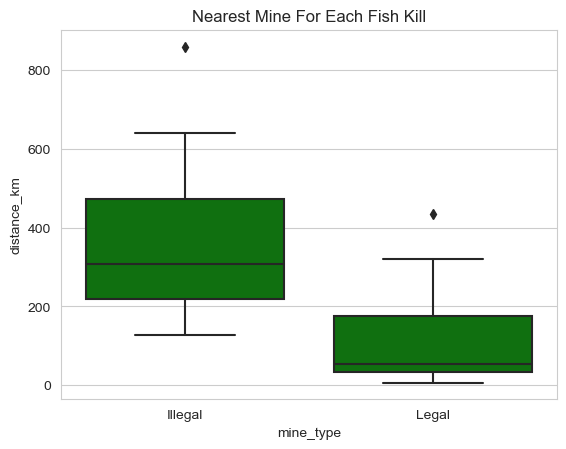

In [65]:
sns.set_style("whitegrid") 
  
sns.boxplot(x = 'mine_type', y = 'distance_km', data = nm, color='green').set_title("Nearest Mine For Each Fish Kill")


Text(0.5, 1.0, 'Nearest Fish Kill For Each Mine')

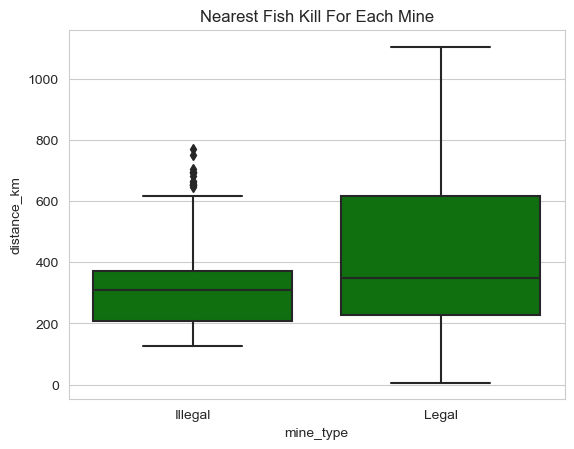

In [66]:
sns.boxplot(x = 'mine_type', y = 'distance_km', data = fk, color='green').set_title("Nearest Fish Kill For Each Mine")

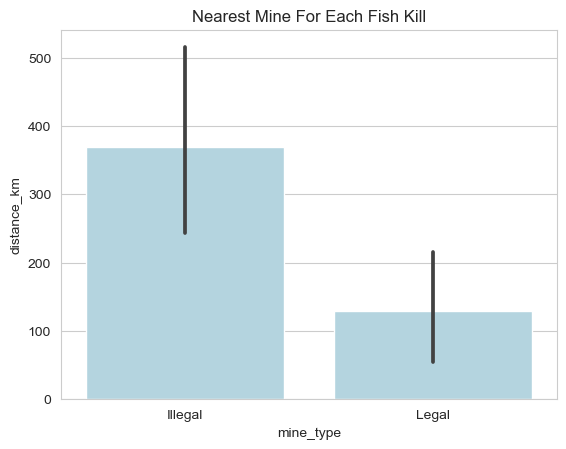

In [67]:

plt.figure()

# plot a bar chart
ax = sns.barplot(x="mine_type", y="distance_km", data=nm, estimator=np.mean, color='lightblue').set_title("Nearest Mine For Each Fish Kill")


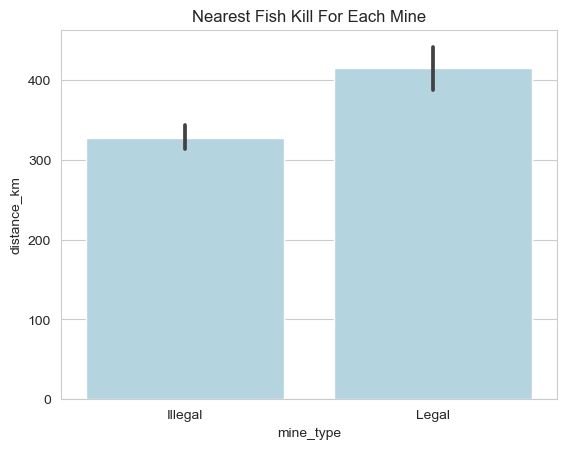

In [68]:
plt.figure()

# plot a bar chart
ax = sns.barplot(x="mine_type", y="distance_km", data=fk, estimator=np.mean, color='lightblue').set_title("Nearest Fish Kill For Each Mine")

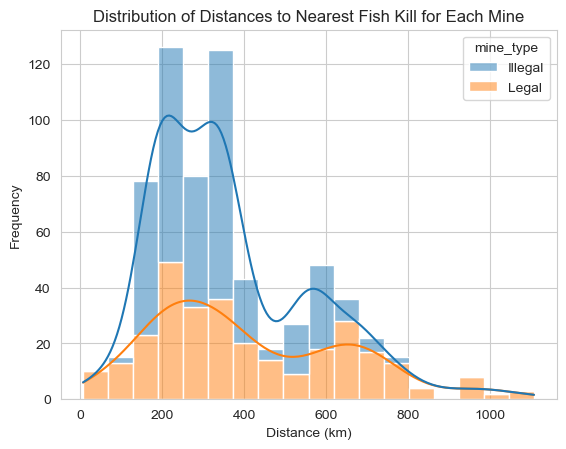

In [69]:
# Create a histogram
sns.histplot(data=fk, x='distance_km', hue='mine_type', kde=True, multiple='stack')

# Display the plot
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Distribution of Distances to Nearest Fish Kill for Each Mine')
plt.show()

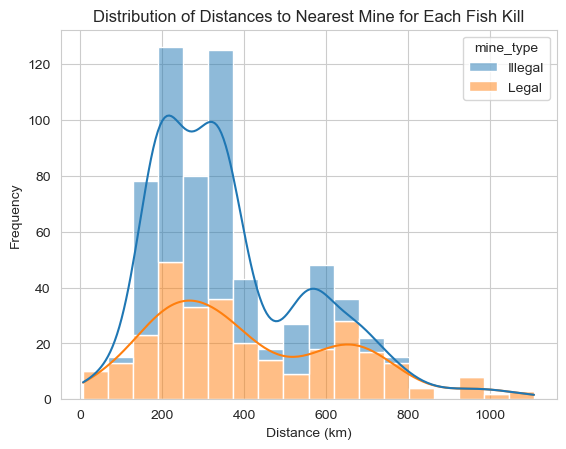

In [70]:
# Create a histogram
sns.histplot(data=fk, x='distance_km', hue='mine_type', kde=True, multiple='stack')

# Display the plot
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.title('Distribution of Distances to Nearest Mine for Each Fish Kill')
plt.show()

In [71]:
fk

,mine_id,UF,distance_km,number_of_fish,number_of_species,mine_type,mean_value,mean_number,mean_carnivorous_value,mean_carnivorous_number,mean_non_carnivorous_value,mean_non_carnivorous_number
4,48,Maraã (AM),588.137112,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
14,61,Maraã (AM),590.948230,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
24,66,Maraã (AM),560.412052,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
34,67,Maraã (AM),567.813190,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
44,68,Maraã (AM),571.267422,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
...,...,...,...,...,...,...,...,...,...,...,...,...
295,886293,Manaus (AM),980.590346,51,18,Legal,0.42,0.53,0.85,21,0.12,30
296,855127,Itaituba (PA),352.355347,71,24,Legal,0.29,0.39,0.65,26,0.08,45
297,886149,Tefé (AM),711.441415,47,16,Legal,0.13,0.15,0.3,15,0.05,32
298,850879,Itaituba (PA),317.567373,71,24,Legal,0.29,0.39,0.65,26,0.08,45


In [77]:
for col in ["distance_km", "mean_value", "mean_carnivorous_value", "mean_non_carnivorous_value"]:
    fk[col] = pd.to_numeric(fk[col], errors='coerce')

# Initialize a dictionary to store correlation results
correlations_by_mine_type = {}

# Loop through each mine type to calculate correlations
for mine_type, group in fk.groupby("mine_type"):
    # Calculate correlations with 'distance_km' for specified columns
    correlations = group[["distance_km", "mean_value", "mean_carnivorous_value", "mean_non_carnivorous_value"]].corr()["distance_km"]
    # Drop the self-correlation (distance_km with distance_km)
    correlations = correlations.drop("distance_km")
    correlations_by_mine_type[mine_type] = correlations

# Display results
correlations_by_mine_type

{'Illegal': mean_value                   -0.374037
 mean_carnivorous_value       -0.362965
 mean_non_carnivorous_value    0.470850
 Name: distance_km, dtype: float64,
 'Legal': mean_value                   -0.132083
 mean_carnivorous_value       -0.269582
 mean_non_carnivorous_value   -0.022801
 Name: distance_km, dtype: float64}

In [78]:
for col in ["distance_km", "mean_value", "mean_carnivorous_value", "mean_non_carnivorous_value"]:
    nm[col] = pd.to_numeric(nm[col], errors='coerce')

# Initialize a dictionary to store correlation results
correlations_by_mine_type = {}

# Loop through each mine type to calculate correlations
for mine_type, group in nm.groupby("mine_type"):
    # Calculate correlations with 'distance_km' for specified columns
    correlations = group[["distance_km", "mean_value", "mean_carnivorous_value", "mean_non_carnivorous_value"]].corr()["distance_km"]
    # Drop the self-correlation (distance_km with distance_km)
    correlations = correlations.drop("distance_km")
    correlations_by_mine_type[mine_type] = correlations

# Display results
correlations_by_mine_type

{'Illegal': mean_value                    0.481733
 mean_carnivorous_value        0.376182
 mean_non_carnivorous_value    0.660504
 Name: distance_km, dtype: float64,
 'Legal': mean_value                    0.261595
 mean_carnivorous_value       -0.049766
 mean_non_carnivorous_value   -0.079746
 Name: distance_km, dtype: float64}

In [74]:
# Convert specified columns to numeric
for col in ["distance_km", "mean_value", "mean_carnivorous_value", "mean_non_carnivorous_value"]:
    nm[col] = pd.to_numeric(nm[col], errors='coerce')

# Initialize a dictionary to store correlation results
correlations_by_mine_type = {}
p_values_by_mine_type = {}

# Loop through each mine type to calculate correlations and p-values
for mine_type, group in nm.groupby("mine_type"):
    # Calculate correlations with 'distance_km' for specified columns
    correlations = group[["distance_km", "mean_value", "mean_carnivorous_value", "mean_non_carnivorous_value"]].corr()["distance_km"]
    
    # Drop the self-correlation
    correlations = correlations.drop("distance_km")
    
    # Store correlations
    correlations_by_mine_type[mine_type] = correlations
    
    # Calculate p-values for each correlation
    p_values = {}
    n = len(group)
    for col in correlations.index:
        r = correlations[col]
        t_stat = r * ((n - 2) ** 0.5) / ((1 - r ** 2) ** 0.5) if r != 1 else float('inf')  # Handle r = 1 case
        p_value = (1 - stats.t.cdf(abs(t_stat), df=n - 2)) * 2  # Two-tailed test
        p_values[col] = p_value
        
    # Store p-values
    p_values_by_mine_type[mine_type] = p_values

# Display results
print("Correlations by Mine Type:")
for mine_type, correlations in correlations_by_mine_type.items():
    print(f"{mine_type}:\n{correlations}\n")

print("P-values by Mine Type:")
for mine_type, p_values in p_values_by_mine_type.items():
    print(f"{mine_type}:\n{p_values}\n")

Correlations by Mine Type:
Illegal:
mean_value                    0.481733
mean_carnivorous_value        0.376182
mean_non_carnivorous_value    0.660504
Name: distance_km, dtype: float64

Legal:
mean_value                    0.261595
mean_carnivorous_value       -0.049766
mean_non_carnivorous_value   -0.079746
Name: distance_km, dtype: float64

P-values by Mine Type:
Illegal:
{'mean_value': 0.15858903789489864, 'mean_carnivorous_value': 0.2839978892511703, 'mean_non_carnivorous_value': 0.03762838341488983}

Legal:
{'mean_value': 0.46533928142784875, 'mean_carnivorous_value': 0.8914053109063764, 'mean_non_carnivorous_value': 0.8266597317828777}



In [93]:
# Convert specified columns to numeric
for col in ["distance_km", "mean_value", "mean_carnivorous_value", "mean_non_carnivorous_value"]:
    fk[col] = pd.to_numeric(fk[col], errors='coerce')

# Initialize a dictionary to store correlation results
correlations_by_mine_type = {}
p_values_by_mine_type = {}

# Loop through each mine type to calculate correlations and p-values
for mine_type, group in fk.groupby("mine_type"):
    # Calculate correlations with 'distance_km' for specified columns
    correlations = group[["distance_km", "mean_value", "mean_carnivorous_value", "mean_non_carnivorous_value"]].corr()["distance_km"]
    
    # Drop the self-correlation
    correlations = correlations.drop("distance_km")
    
    # Store correlations
    correlations_by_mine_type[mine_type] = correlations
    
    # Calculate p-values for each correlation
    p_values = {}
    n = len(group)
    for col in correlations.index:
        r = correlations[col]
        t_stat = r * ((n - 2) ** 0.5) / ((1 - r ** 2) ** 0.5) if r != 1 else float('inf')  # Handle r = 1 case
        p_value = (1 - stats.t.cdf(abs(t_stat), df=n - 2)) * 2  # Two-tailed test
        p_values[col] = p_value
        
    # Store p-values
    p_values_by_mine_type[mine_type] = p_values

# Display results
print("Correlations by Mine Type:")
for mine_type, correlations in correlations_by_mine_type.items():
    print(f"{mine_type}:\n{correlations}\n")

print("P-values by Mine Type:")
for mine_type, p_values in p_values_by_mine_type.items():
    print(f"{mine_type}:\n{p_values}\n")

Correlations by Mine Type:
Illegal:
mean_value                   -0.374037
mean_carnivorous_value       -0.362965
mean_non_carnivorous_value    0.470850
Name: distance_km, dtype: float64

Legal:
mean_value                   -0.132083
mean_carnivorous_value       -0.269582
mean_non_carnivorous_value   -0.022801
Name: distance_km, dtype: float64

P-values by Mine Type:
Illegal:
{'mean_value': 2.1316282072803006e-13, 'mean_carnivorous_value': 1.1890488593735427e-12, 'mean_non_carnivorous_value': 0.0}

Legal:
{'mean_value': 0.0221237818669473, 'mean_carnivorous_value': 2.1603930977498464e-06, 'mean_non_carnivorous_value': 0.6940757950501211}



- print p value in same rows instead of below it
- round each for 3 decimal places (print values)
- calculate "by hand" 
- plotting x, y fish poisoning in one axis and distance in the other. scatter plot
- fix centroid data

mean_carnivorous_value: Correlation of -0.1819

Indicates a weak negative correlation with distance_km.
P-value: 0.0016 (statistically significant). Although the correlation is weak, the low p-value suggests there is evidence to reject the null hypothesis, indicating some relationship, albeit weak.

In [95]:
fk.to_csv('fk.csv')

Correlations and P-values by Mine Type:

Illegal:
mean_value: Correlation = -0.374, P-value = 2.1316282e-13
mean_carnivorous_value: Correlation = -0.363, P-value = 1.18904886e-12
mean_non_carnivorous_value: Correlation = 0.471, P-value = 0.0

Legal:
mean_value: Correlation = -0.132, P-value = 0.0221237818669473
mean_carnivorous_value: Correlation = -0.27, P-value = 2.16039309774985e-06
mean_non_carnivorous_value: Correlation = -0.023, P-value = 0.6940757950501211


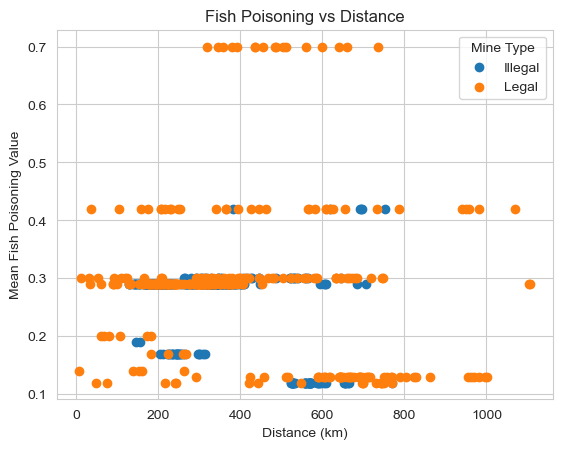

In [100]:
correlations_by_mine_type = {}
p_values_by_mine_type = {}

# Loop through each mine type to calculate correlations and p-values
for mine_type, group in fk.groupby("mine_type"):
    # Calculate correlations with 'distance_km' for specified columns
    correlations = group[["distance_km", "mean_value", "mean_carnivorous_value", "mean_non_carnivorous_value"]].corr()["distance_km"]
    
    # Drop the self-correlation
    correlations = correlations.drop("distance_km")
    
    # Store correlations
    correlations_by_mine_type[mine_type] = correlations
    
    # Calculate p-values for each correlation
    p_values = {}
    n = len(group)
    for col in correlations.index:
        r = correlations[col]
        t_stat = r * ((n - 2) ** 0.5) / ((1 - r ** 2) ** 0.5) if r != 1 else float('inf')  # Handle r = 1 case
        p_value = (1 - stats.t.cdf(abs(t_stat), df=n - 2)) * 2  # Two-tailed test
        p_values[col] = p_value
        
    # Store p-values
    p_values_by_mine_type[mine_type] = p_values

# Display results with correlations and p-values on the same row, rounded to 3 decimal places
print("Correlations and P-values by Mine Type:")
for mine_type, correlations in correlations_by_mine_type.items():
    print(f"\n{mine_type}:")
    for col in correlations.index:
        corr_value = round(correlations[col], 3)
        p_value = round(p_values_by_mine_type[mine_type][col], 20)
        print(f"{col}: Correlation = {corr_value}, P-value = {p_value}")

# Scatter plot for 'mean_value' (fish poisoning) vs 'distance_km'
for mine_type, group in fk.groupby("mine_type"):
    plt.scatter(group['distance_km'], group['mean_value'], label=mine_type)

plt.xlabel('Distance (km)')
plt.ylabel('Mean Fish Poisoning Value')
plt.title('Fish Poisoning vs Distance')
plt.legend(title="Mine Type")
plt.show()

In [98]:
fk

,mine_id,UF,distance_km,number_of_fish,number_of_species,mine_type,mean_value,mean_number,mean_carnivorous_value,mean_carnivorous_number,mean_non_carnivorous_value,mean_non_carnivorous_number
4,48,Maraã (AM),588.137112,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
14,61,Maraã (AM),590.948230,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
24,66,Maraã (AM),560.412052,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
34,67,Maraã (AM),567.813190,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
44,68,Maraã (AM),571.267422,48,15,Illegal,0.12,0.12,0.33,6,0.10,42
...,...,...,...,...,...,...,...,...,...,...,...,...
295,886293,Manaus (AM),980.590346,51,18,Legal,0.42,0.53,0.85,21,0.12,30
296,855127,Itaituba (PA),352.355347,71,24,Legal,0.29,0.39,0.65,26,0.08,45
297,886149,Tefé (AM),711.441415,47,16,Legal,0.13,0.15,0.30,15,0.05,32
298,850879,Itaituba (PA),317.567373,71,24,Legal,0.29,0.39,0.65,26,0.08,45
